# Movie Recommendation using Netflix Movie Reviews




This project aims to build a movie recommendation system using Netflix Movie Ratings. There are 17337458 Ratings given by 143458 users to 1350 movies. Ratings are in the form of Integer i.e. 1 - 5

### *Please Upvote if this notebook is helpful to you in some ways!*
So let's get started


**Table of Content**



#### 1.  Load Rating Data
#### 2.  Load Movie Data
#### 3.  Analyze Data
#### 4.  Recommendation Model
#### 4.1 Collaborative Filtering - SVD
#### 4.2 Pearson Correlation Method

In [1]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

# 1. Load Rating Data

In [2]:
df = pd.read_csv('../input/netflix-movie-rating-dataset/Netflix_Dataset_Rating.csv')
df

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3
...,...,...,...
17337453,520675,3,4496
17337454,1055714,5,4496
17337455,2643029,4,4496
17337456,1559566,3,4496


In [3]:
df.dtypes

User_ID     int64
Rating      int64
Movie_ID    int64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   User_ID   int64
 1   Rating    int64
 2   Movie_ID  int64
dtypes: int64(3)
memory usage: 396.8 MB


In [5]:
df['Rating'].describe().astype('int')

count    17337458
mean            3
std             1
min             1
25%             3
50%             4
75%             4
max             5
Name: Rating, dtype: int64

In [6]:
print("Unique Values :\n",df.nunique())

Unique Values :
 User_ID     143458
Rating           5
Movie_ID      1350
dtype: int64


# 2. Load Movie Data

In [7]:
df_title = pd.read_csv('../input/netflix-movie-rating-dataset/Netflix_Dataset_Movie.csv')
df_title

,Movie_ID,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [8]:
df_title.dtypes

Movie_ID     int64
Year         int64
Name        object
dtype: object

In [9]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie_ID  17770 non-null  int64 
 1   Year      17770 non-null  int64 
 2   Name      17770 non-null  object
dtypes: int64(2), object(1)
memory usage: 416.6+ KB


In [10]:
df_title['Year'].describe().astype('int')

count    17770
mean      1990
std         16
min       1915
25%       1985
50%       1997
75%       2002
max       2005
Name: Year, dtype: int64

In [11]:
print("Unique Values :\n",df_title.nunique())

Unique Values :
 Movie_ID    17770
Year           91
Name        17297
dtype: int64


# 3. Analyze Data

In [12]:
no_of_rated_products_per_users = df.groupby(by='User_ID')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_users.head()

User_ID
305344     1344
387418     1339
2439493    1324
2118461    1305
1664010    1257
Name: Rating, dtype: int64

In [13]:
no_of_rated_products_per_users.describe()


count    143458.000000
mean        120.853895
std          79.783702
min           5.000000
25%          67.000000
50%          95.000000
75%         147.000000
max        1344.000000
Name: Rating, dtype: float64

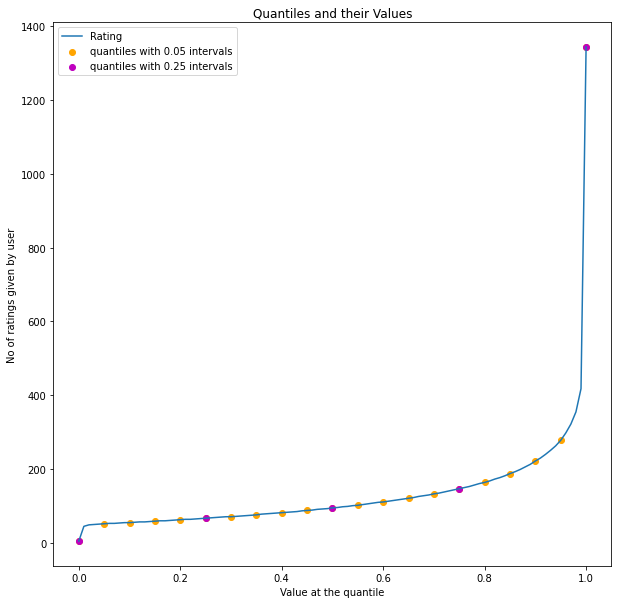

In [14]:
quantiles = no_of_rated_products_per_users.quantile(np.arange(0,1.01,0.01), interpolation='higher')

plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings given by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [15]:
no_of_rated_products_per_movies = df.groupby(by='Movie_ID')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_movies.head()

Movie_ID
1905    117075
2452    102721
4306    102376
571     101450
3860     98545
Name: Rating, dtype: int64

In [16]:
no_of_rated_products_per_movies.describe()

count      1350.000000
mean      12842.561481
std       17805.334719
min        1042.000000
25%        2607.750000
50%        5229.000000
75%       14792.000000
max      117075.000000
Name: Rating, dtype: float64

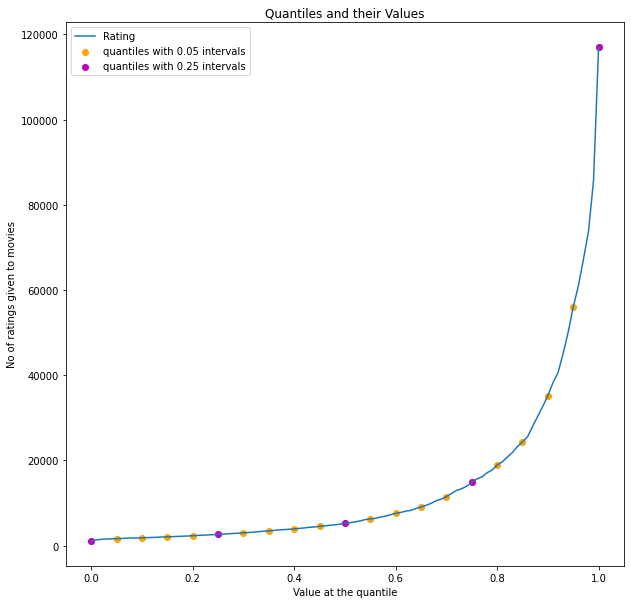

In [17]:
quantiles = no_of_rated_products_per_movies.quantile(np.arange(0,1.01,0.01), interpolation='higher')

plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings given to movies')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [18]:
f = ['count','mean']
df_movie_summary = df.groupby('Movie_ID')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

df__title = df_title.set_index('Movie_ID')

In [19]:
data = df['Rating'].value_counts()

trace = go.Bar(x = data.index,y = data.values,text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],textposition = 'auto')

layout = dict(title = 'Distribution of {} Movie-ratings'.format(df.shape[0]), xaxis = dict(title = 'Rating'), yaxis = dict(title = 'Movies'))

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

In [20]:
data = df_title['Year'].value_counts()

trace = go.Bar(x = data.index,y = data.values,text = ['{:.1f} %'.format(val) for val in (data.values / df_title.shape[0] * 100)],textposition = 'auto')

layout = dict(title = 'Distribution of {} Movie - Year-wise'.format(df.shape[0]), xaxis = dict(title = 'Year'), yaxis = dict(title = 'Movies'))

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

In [21]:
df_2004 = df_title[df_title['Year']==2004]
df_2004 = df_2004.merge(df,on='Movie_ID')

data = df_2004['Rating'].value_counts()

trace = go.Bar(x = data.index,y = data.values,text = ['{:.1f} %'.format(val) for val in (data.values / df_2004.shape[0] * 100)],textposition = 'auto')

layout = dict(title = 'Distribution of {} Movie-ratings released in 2004'.format(df.shape[0]), xaxis = dict(title = 'Rating'), yaxis = dict(title = 'Movies'))

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

In [22]:
df_max_ratings = df_movie_summary[df_movie_summary['count']==df_movie_summary['count'].max()]

req_MID = df_max_ratings.index[0]
df_max_ratings = df[df['Movie_ID'] ==req_MID]

Movie_name_max_raings = df_title['Name'][df_title['Movie_ID']==req_MID].to_string(index=False)

data = df_max_ratings['Rating'].value_counts()

trace = go.Bar(x = data.index,y = data.values,text = ['{:.1f} %'.format(val) for val in (data.values / df_max_ratings.shape[0] * 100)],textposition = 'auto')

layout = dict(title = 'Distribution of Most Rated Movie -'+Movie_name_max_raings+ ' Movie-Ratings')

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

# 4. Recommendation Model


## 4.1 Collaborative Filtering - SVD

In [23]:
model = SVD(n_epochs=10,verbose = True)

data = Dataset.load_from_df(df[['User_ID', 'Movie_ID', 'Rating']], Reader())

trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

trainset = data.build_full_trainset()

model.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [24]:
predictions = model.test(testset)

accuracy.rmse(predictions, verbose=True)

RMSE: 0.8300


0.830024564649771

In [25]:
def Recommendation(given_user_id,n_movies):
    given_user = df_title.copy()
    given_user = given_user.reset_index()
    given_user = given_user[~given_user['Movie_ID'].isin(drop_movie_list)]


    given_user['Estimated_Rating'] = given_user['Movie_ID'].apply(lambda x: model.predict(given_user_id, x).est)

    given_user = given_user.drop('Movie_ID', axis = 1)

    given_user = given_user.sort_values('Estimated_Rating', ascending=False)
    given_user.drop(['index'], axis = 1,inplace=True)
    given_user.reset_index(inplace=True,drop=True)
    return given_user.head(n_movies)

### Movie Recommendation for User - 712664

In [26]:
Recommendation(712664,10)

,Year,Name,Estimated_Rating
0,1954,Seven Samurai,4.992492
1,1990,The Simpsons: Treehouse of Horror,4.875574
2,1992,Reservoir Dogs,4.814086
3,1991,The Simpsons: Season 3,4.807037
4,1949,The Third Man,4.725118
5,1989,The Simpsons: Season 1,4.716759
6,1959,North by Northwest,4.706894
7,1974,The Godfather,4.702629
8,2002,Spirited Away,4.673331
9,2003,Chappelle's Show: Season 1,4.634730


### Movie Recommendation for User - 2643029

In [27]:
Recommendation(2643029,10)

,Year,Name,Estimated_Rating
0,1954,Seven Samurai,4.731809
1,2002,Spirited Away,4.652380
2,1992,Reservoir Dogs,4.567584
3,2002,The Pianist,4.557840
4,2001,Wallace & Gromit in Three Amazing Adventures,4.551845
5,1995,Pride and Prejudice,4.538372
6,1990,The Simpsons: Treehouse of Horror,4.512210
7,1974,The Godfather,4.476648
8,1959,North by Northwest,4.474071
9,2001,Lord of the Rings: The Fellowship of the Ring,4.465811


## 4.2 Pearson Correlation Method

In [28]:
df_p = pd.pivot_table(df,values='Rating',index='User_ID',columns='Movie_ID')

def Recommend_based_on_movie(movie_title, min_count):
    i = int(df__title.index[df__title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df__title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    corr_target = corr_target[corr_target['count']>min_count][:10]
    corr_target.reset_index(drop=True,inplace=True)
    return corr_target

### Recommendation based on given movie - "The Education of Little Tree"

In [29]:
Recommend_based_on_movie("The Education of Little Tree", 0)

,PearsonR,Name,count,mean
0,1.000000,The Education of Little Tree,1298,3.640986
1,0.849023,Stoked: The Rise and Fall of Gator,1454,3.388583
2,0.774597,Life and Debt,1438,3.574409
3,0.768520,Carandiru,1249,3.599680
4,0.756284,Scratch,1706,3.783118
5,0.755746,Night and Fog,1455,3.890034
6,0.741415,Tupac: Resurrection,2367,3.701310
7,0.728919,Concert for George,1861,3.926921
8,0.721686,Rififi,1798,3.929922
9,0.710505,Unprecedented: The 2000 Presidential Election,2109,3.760076


### Recommendation based on given movie - "Character"

In [30]:
Recommend_based_on_movie("Character", 0)

,PearsonR,Name,count,mean
0,1.000000,Character,1524,3.621391
1,0.714448,The Autobiography of Miss Jane Pittman,1772,3.977991
2,0.713041,Father's Little Dividend,1788,3.300336
3,0.712606,Operation Pacific,1590,3.757862
4,0.693215,Samurai Champloo,1327,4.395629
5,0.691037,Holiday in the Sun,1468,3.297003
6,0.686939,Spencer's Mountain,2269,3.825914
7,0.681311,MI-5: Vol. 2,1356,4.091445
8,0.681279,Foyle's War: Set 2,1506,4.116202
9,0.681250,U2: Go Home: Live From Slane Castle,1285,3.939300
